#### Import libraries

In [1]:
import pandas as pd
import math
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import pmdarima as pm
from pmdarima import auto_arima

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import plotly.io as pio

In [2]:
# To render plotly into GitHub
pio.renderers.default = "svg"

In [3]:
# Select country in analysis ('FIN', 'DEN', 'NOR', 'SWE')
country = 'DEN'

# Dependant variable
dep_var = 'TIV'     

# Exogenous variable for SARIMAX
exo_var = 'Orders'

### Load Data

In [4]:
# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + '0.xlsx'
df = pd.read_excel(file, sheet_name=country)

# Set index  
df = df.set_index("Date").asfreq('MS')

In [5]:
df

,Orders,CPI,UR,LTIR,TIV
Date,,,,,
2006-01-01,161,2.184466,4.1,3.311,65.640787
2006-02-01,250,2.163461,4.2,3.484,61.924395
2006-03-01,468,1.911589,4.2,3.704,83.479473
2006-04-01,412,1.902497,4.2,3.975,77.672609
2006-05-01,550,2.021403,4.1,4.022,91.928459
...,...,...,...,...,...
2022-08-01,343,8.909952,4.5,1.375,74.473027
2022-09-01,337,10.018900,4.6,2.200,75.796992
2022-10-01,322,10.112360,4.6,2.599,63.242553


### Split Data

In [6]:
steps = 36  # 36 months of testing
train = df[:-steps]
test  = df[-steps:]

start=len(train)
end=len(train)+len(test)-1

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

Dataset length : (n=204)
Train dates    : 2006-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=168)
Test dates     : 2020-01-01 00:00:00 --- 2022-12-01 00:00:00  (n=36)


### Scoring function

In [7]:
metrics = pd.DataFrame()

# Accuracy metrics
def forecast_accuracy(model_name, y_true, y_pred, print_metrics: bool, plot_results: bool):
    
    mae = np.mean(np.abs(y_pred - y_true))                                    # MAE
    mse = mean_squared_error(y_true, y_pred)                                  # MSE (Mean Squared Error)
    rmse = math.sqrt(mse)                                                     # RMSE (Root Mean Squared Error)    
    r2 = r2_score(y_true, y_pred)                                             # R2 (R-squared - Coeficient of determination)      
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true)*100)                # MAPE        
    accuracy = 100 - mape                                                     # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, mse, rmse, r2, mape, accuracy]
    metrics.index = ['Mean Absolute Error', 
                    'Mean Squared Error', 
                    'Root Mean Squared Error',
                    'R^2',
                    'Mean Absolute Percentage Error',
                    'Accuracy']       

    # Print metrics  
    if print_metrics:
 
        print(model_name, 'Model Performance:')                             # Model name
        print('Mean Absolute Error: {:0.2f}.'.format(mae))                  # MAE
        print('Mean Squared Error: {:0.2f}.'.format(mse))                   # MSE
        print('Root Mean Squared Error: {:0.2f}.'.format(rmse))             # RMSE  
        print('R^2 Score = {:0.2f}.'.format(r2))                            # R2
        print('Mean Absolute Percentage Error: {:0.2f}%.'.format(mape))     # MAPE 
        print('Accuracy = {:0.2f}%.'.format(accuracy))                      # Accuracy                    
    
    # Plot Actual values vs predicted values
    if plot_results:
        
        df = pd.DataFrame(y_true)

        fig= make_subplots(rows=2, cols=1)
        
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_true, mode='lines', name= 'Actual'), legendgroup="Preds"), row=1, col=1)
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_pred, mode='lines', name= 'Predicted'), legendgroup="Preds"), row=1, col=1)
        
        fig.add_trace(go.Scatter(dict(x=train.index, y=train[dep_var], mode='lines', name= 'Train'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=test[dep_var], mode='lines', name= 'Test'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=y_pred, mode='lines', name= 'Forecast'), legendgroup="Full"), row=2, col=1)

        fig.update_layout(height=600, width=1000, title_text=model_name + " Predictions - " + country)    

        fig.show()  

                    

### Modeling

#### Simple Exponential Smoothing

Simple Exponential Smoothing Model Performance:
Mean Absolute Error: 22.72.
Mean Squared Error: 736.20.
Root Mean Squared Error: 27.13.
R^2 Score = -0.72.
Mean Absolute Percentage Error: 31.43%.
Accuracy = 68.57%.


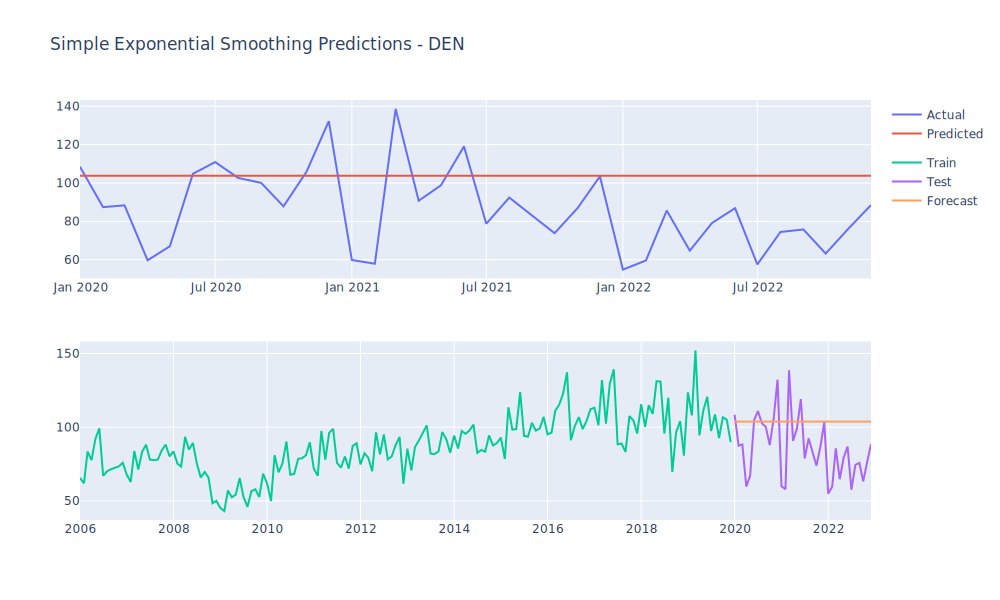

In [8]:
model_name='Simple Exponential Smoothing'
span = 12
alpha = 2/(span+1)

# Train
model = SimpleExpSmoothing(train[dep_var]).fit(smoothing_level=alpha,optimized=False)

# Predict
predictions = model.predict(start=start, end=end)

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

#### Double Explonential Smoothing

Double Exponential Smoothing Model Performance:
Mean Absolute Error: 24.46.
Mean Squared Error: 837.06.
Root Mean Squared Error: 28.93.
R^2 Score = -0.95.
Mean Absolute Percentage Error: 33.82%.
Accuracy = 66.18%.


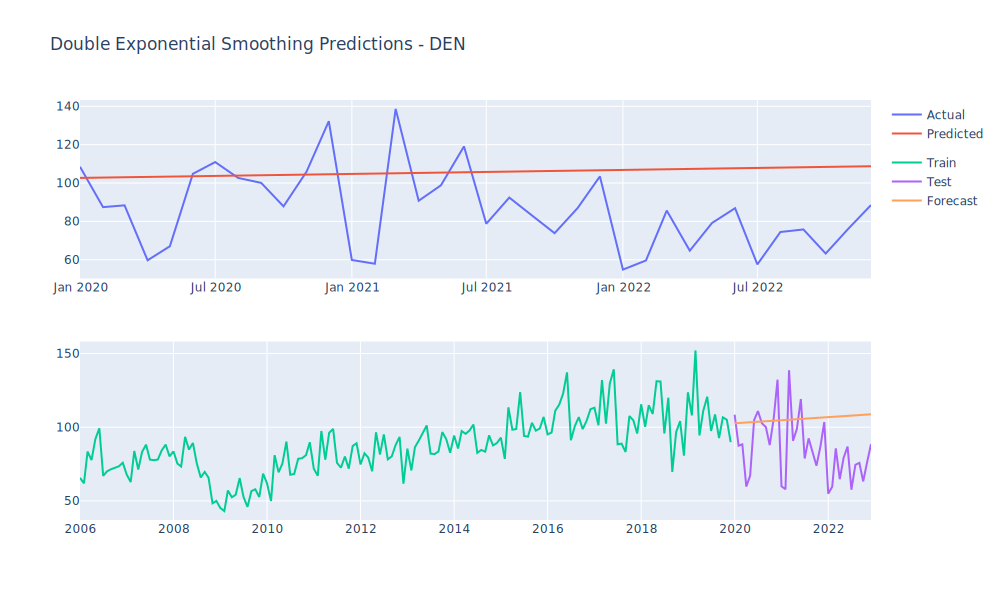

In [9]:
model_name='Double Exponential Smoothing'

# Train
model = ExponentialSmoothing(train[dep_var],trend='add',seasonal_periods=12).fit()
# Predict
predictions = model.predict(start=start, end=end)

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

#### Triple Exponential Smoothing

Triple Exponential Smoothing Model Performance:
Mean Absolute Error: 25.06.
Mean Squared Error: 858.16.
Root Mean Squared Error: 29.29.
R^2 Score = -1.00.
Mean Absolute Percentage Error: 34.28%.
Accuracy = 65.72%.


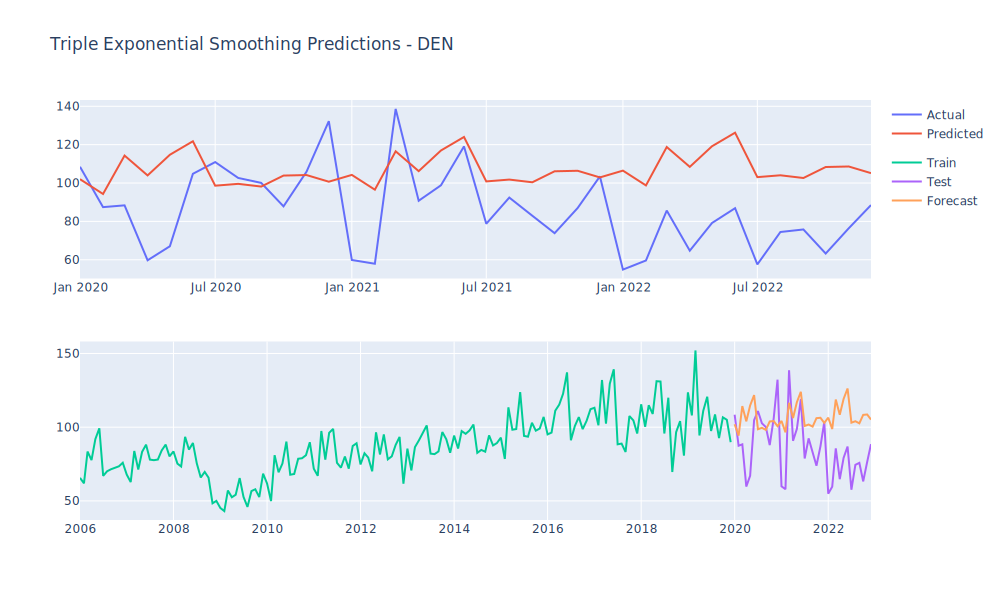

In [10]:
model_name='Triple Exponential Smoothing'

# Train
model = ExponentialSmoothing(train[dep_var],trend='add',seasonal='add',seasonal_periods=12).fit()

# Predict
predictions = model.predict(start=start, end=end)

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

In [11]:
metrics

,Simple Exponential Smoothing,Double Exponential Smoothing,Triple Exponential Smoothing
Mean Absolute Error,22.715779,24.455470,25.060178
Mean Squared Error,736.196571,837.055108,858.155875
Root Mean Squared Error,27.132943,28.931905,29.294298
R^2,-0.715648,-0.950691,-0.999864
Mean Absolute Percentage Error,31.431946,33.821299,34.282128
Accuracy,68.568054,66.178701,65.717872


#### ARIMA

In [12]:
#Standard ARIMA Model
model = auto_arima(train[dep_var], 
                    start_p=1, 
                    start_q=1,
                    test='adf',                 # Use adftest to find optimal 'd'
                    max_p=3, max_q=3,           # Maximum p and q
                    m=1,                        # Frequency of series (if m==1, seasonal is set to FALSE automatically)
                    d=None,                     # Let model determine 'd'
                    seasonal=False,             # No Seasonality for standard ARIMA
                    trace=True,                 # Logs 
                    error_action= 'warn',       # Shows errors ('ignore' silences these)
                    suppress_warnings=True,
                    stepwise=True)                    

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1350.790, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1990.537, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1420.659, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1802.877, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1352.782, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1352.784, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1742.687, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1351.158, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1347.468, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1435.540, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1390.179, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1349.432, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1349.445, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : 

In [13]:
#model.plot_diagnostics(figsize=(15,12))
#plt.show()

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  168
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -669.734
Date:                Thu, 16 Feb 2023   AIC                           1347.468
Time:                        16:57:25   BIC                           1359.964
Sample:                    01-01-2006   HQIC                          1352.540
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.1649      1.763      1.228      0.219      -1.290       5.619
ar.L1          0.9753      0.020     49.484      0.000       0.937       1.014
ma.L1         -0.7267      0.059    -12.269      0.000      -0.843      -0.611
sigma2       168.5761     15.286     11.028      0.000     138.617     198.535
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 6.84
Prob(Q):                              0.88   Prob(JB):                         0.03
Heteroskedasticity (H):               2.45   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA Model Performance:
Mean Absolute Error: 18.19.
Mean Squared Error: 492.57.
Root Mean Squared Error: 22.19.
R^2 Score = -0.15.
Mean Absolute Percentage Error: 24.48%.
Accuracy = 75.52%.


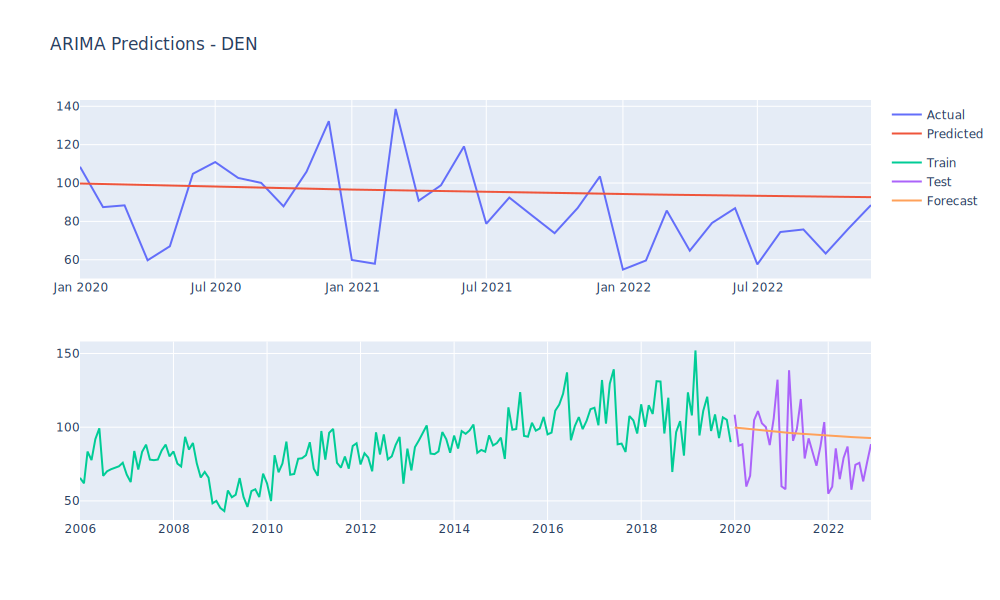

In [15]:
model_name='ARIMA'

# Predict
predictions = model.predict(n_periods=test.shape[0], dynamic=False, typ='levels')

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

In [16]:
metrics

,Simple Exponential Smoothing,Double Exponential Smoothing,Triple Exponential Smoothing,ARIMA
Mean Absolute Error,22.715779,24.455470,25.060178,18.191573
Mean Squared Error,736.196571,837.055108,858.155875,492.569237
Root Mean Squared Error,27.132943,28.931905,29.294298,22.193901
R^2,-0.715648,-0.950691,-0.999864,-0.147894
Mean Absolute Percentage Error,31.431946,33.821299,34.282128,24.481434
Accuracy,68.568054,66.178701,65.717872,75.518566


#### SARIMA

In [17]:
# Seasonal - fit stepwise auto-ARIMA
model = auto_arima(train[dep_var],
                    start_p=1, 
                    start_q=1,
                    test='adf',                 # Use adftest to find optimal 'd'
                    max_p=3, max_q=3,           # Maximum p and q
                    m=12,                       # Frequency of series (if m==1, seasonal is set to FALSE automatically) - 12 months
                    start_P=0, 
                    seasonal=True,              # set to seasonal
                    d=None,                     # Let model determine 'd'
                    D=1,                        # Order of the seasonal differencing
                    trace=True,                 # Logs 
                    error_action='warn',        # Shows errors ('ignore' silences these)
                    suppress_warnings=True, 
                    stepwise=True)  

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1185.358, Time=0.31 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1283.283, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1223.887, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1186.049, Time=0.20 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1223.179, Time=0.06 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1185.652, Time=0.49 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1185.678, Time=1.15 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1203.274, Time=0.32 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1187.620, Time=2.25 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1204.471, Time=0.40 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1183.283, Time=0.81 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1220.804, Time=0.38 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1184.284, Time=1.55 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=1184.372, Time=4.02 sec
 ARIMA(2,1,1)(1,1,0

In [18]:
#model.plot_diagnostics(figsize=(15,12))
#plt.show()

In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  168
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -587.075
Date:                              Thu, 16 Feb 2023   AIC                           1182.150
Time:                                      16:57:49   BIC                           1194.323
Sample:                                  01-01-2006   HQIC                          1187.094
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7492      0.058    -12.854      0.000      -0.863      -0.635
ar.L2         -0.3816      0.061     -6.254      0.000      -0.501      -0.262
ma.S.L12      -0.7067      0.077     -9.133      0.000      -0.858      -0.555
sigma2       107.7114      9.828     10.960      0.000      88.449     126.973
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                20.58
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               2.94   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA Model Performance:
Mean Absolute Error: 25.71.
Mean Squared Error: 921.50.
Root Mean Squared Error: 30.36.
R^2 Score = -1.15.
Mean Absolute Percentage Error: 35.05%.
Accuracy = 64.95%.


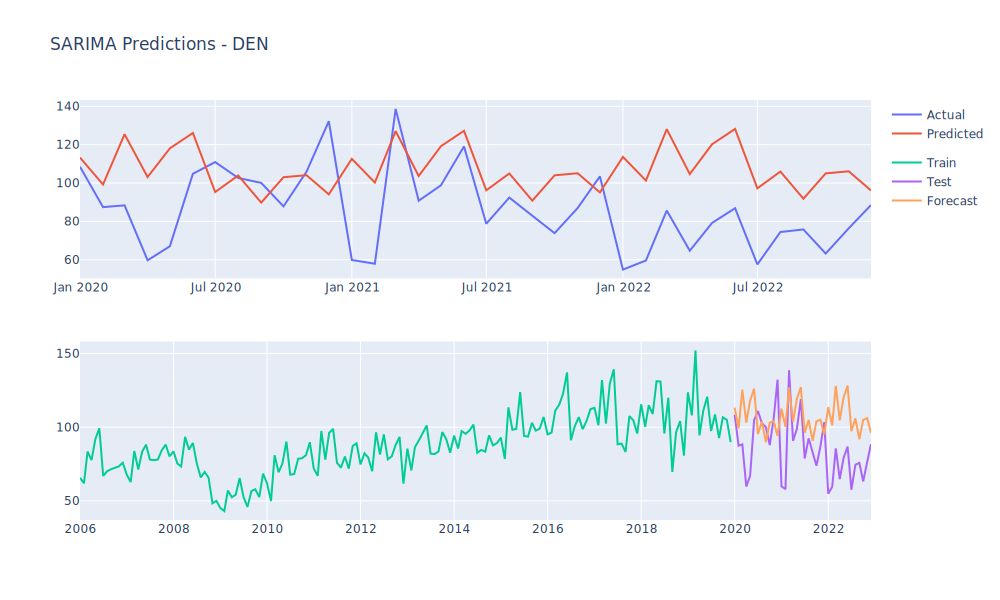

In [20]:
model_name='SARIMA'

# Predict
predictions = model.predict(n_periods=test.shape[0], dynamic=False, typ='levels')

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

In [21]:
metrics

,Simple Exponential Smoothing,Double Exponential Smoothing,Triple Exponential Smoothing,ARIMA,SARIMA
Mean Absolute Error,22.715779,24.455470,25.060178,18.191573,25.709606
Mean Squared Error,736.196571,837.055108,858.155875,492.569237,921.501618
Root Mean Squared Error,27.132943,28.931905,29.294298,22.193901,30.356245
R^2,-0.715648,-0.950691,-0.999864,-0.147894,-1.147487
Mean Absolute Percentage Error,31.431946,33.821299,34.282128,24.481434,35.047868
Accuracy,68.568054,66.178701,65.717872,75.518566,64.952132


#### SARIMAX

In [22]:
# SARIMAX = SARIMA with exogenous variable
model = auto_arima(train[dep_var], exogenous=train[[exo_var]],
                           start_p=1, 
                           start_q=1,
                           test='adf',
                           max_p=3, max_q=3, 
                           m=12,
                           start_P=0, 
                           seasonal=True,
                           d=None, 
                           D=1, 
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1185.358, Time=0.30 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1283.283, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1223.887, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1186.049, Time=0.20 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1223.179, Time=0.06 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1185.652, Time=0.49 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1185.678, Time=0.93 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1203.274, Time=0.18 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1187.620, Time=1.40 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1204.471, Time=0.18 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1183.283, Time=0.36 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1220.804, Time=0.07 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1184.284, Time=0.75 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=1184.372, Time=1.35 sec
 ARIMA(2,1,1)(1,1,0

In [23]:
#model.plot_diagnostics(figsize=(15,12))
#plt.show()

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  168
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -587.075
Date:                              Thu, 16 Feb 2023   AIC                           1182.150
Time:                                      16:58:06   BIC                           1194.323
Sample:                                  01-01-2006   HQIC                          1187.094
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7492      0.058    -12.854      0.000      -0.863      -0.635
ar.L2         -0.3816      0.061     -6.254      0.000      -0.501      -0.262
ma.S.L12      -0.7067      0.077     -9.133      0.000      -0.858      -0.555
sigma2       107.7114      9.828     10.960      0.000      88.449     126.973
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                20.58
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               2.94   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMAX Model Performance:
Mean Absolute Error: 22.13.
Mean Squared Error: 689.97.
Root Mean Squared Error: 26.27.
R^2 Score = -0.61.
Mean Absolute Percentage Error: 29.85%.
Accuracy = 70.15%.


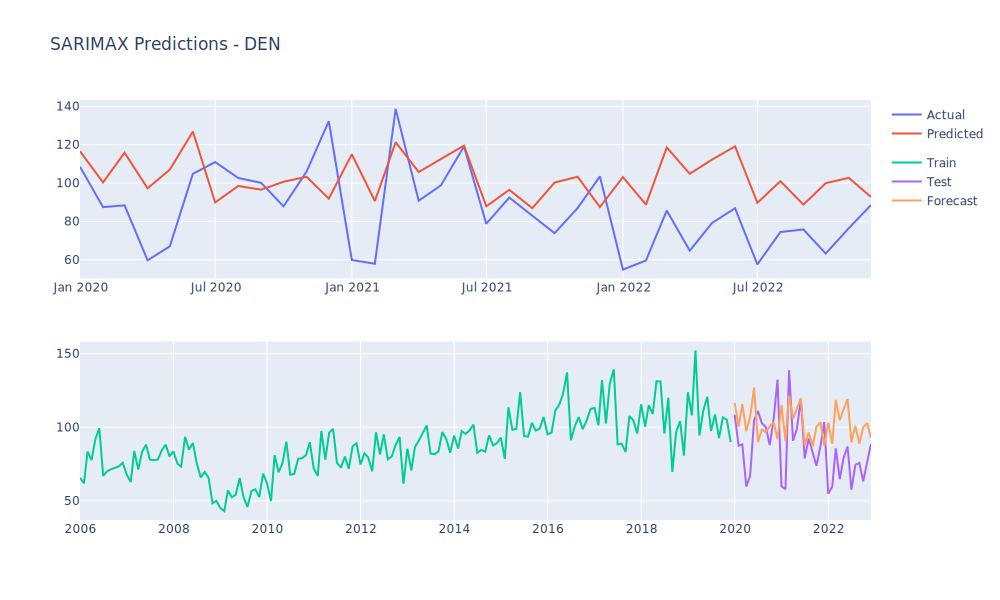

In [25]:
model_name='SARIMAX'

# Build model
model = sm.tsa.statespace.SARIMAX(train[dep_var],order=(0,1,2),seasonal_order=(0,1,1,12),exog = train[exo_var]).fit()

# Predict
predictions = model.predict(start=start, end=end, exog = test[exo_var],  dynamic=False, typ='levels')

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

### Summary

In [26]:
metrics

,Simple Exponential Smoothing,Double Exponential Smoothing,Triple Exponential Smoothing,ARIMA,SARIMA,SARIMAX
Mean Absolute Error,22.715779,24.455470,25.060178,18.191573,25.709606,22.130814
Mean Squared Error,736.196571,837.055108,858.155875,492.569237,921.501618,689.971738
Root Mean Squared Error,27.132943,28.931905,29.294298,22.193901,30.356245,26.267313
R^2,-0.715648,-0.950691,-0.999864,-0.147894,-1.147487,-0.607925
Mean Absolute Percentage Error,31.431946,33.821299,34.282128,24.481434,35.047868,29.845309
Accuracy,68.568054,66.178701,65.717872,75.518566,64.952132,70.154691


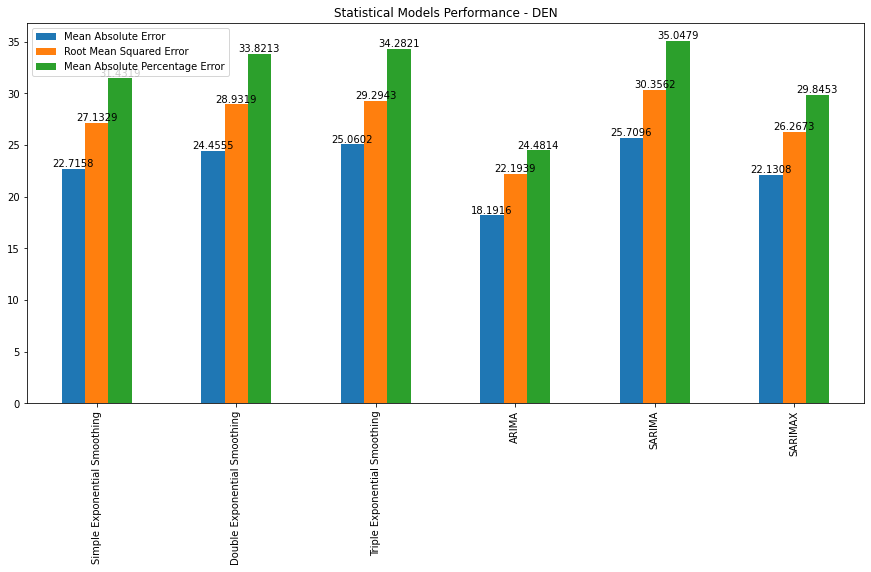

In [27]:
chart = metrics.transpose()
chart.drop(['Mean Squared Error', 'R^2', 'Accuracy'], axis=1, inplace=True)

ax = chart.plot.bar(title="Statistical Models Performance - " + country, figsize=(15,7))
for container in ax.containers:
    ax.bar_label(container)